# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, Iterator, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchnlp.metrics import get_moses_multi_bleu

from decoder import Decoder
from encoder import Encoder
from attention import Attention
# others
import argparse
from NMTutils import get_parser, build_data, get_model_config, evaluation
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict

In [2]:
# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.cuda.current_device()
USE_CUDA = False
DEVICE = -1

## Prepare Loader

In [4]:
lang1 = 'eng'
lang2 = 'fra'
modelcode_small = ['111301', '111311', '111301', '111311', '111311', 
                  '111311', '111311', '122421', '122521', '122621',
                  '122622', '222421', '222521', '222421']
modelcode_filtered = ['322521', '322421']

model_idx = 1
config, test_data, test_loader, SOURCE, TARGET = get_model_config(modelcode_small[model_idx-1], lang1, lang2,
                                                                 device=DEVICE)

In [5]:
def get_source_reference(data, filter_num=1):
    temp = defaultdict(list)
    for d in data.examples:
        src = ' '.join(d.so)
        tar = ' '.join(d.ta)
        temp[src].append(tar)
    
    temp = {k: v for k, v in temp.items() if len(v) >= filter_num}
    return temp

In [6]:
so_ref_dict = get_source_reference(test_data, filter_num=1)

In [8]:
x = list(so_ref_dict.items())
x[0]

('i have just eaten lunch .', ['je viens juste de finir de dejeuner .'])

In [9]:
hypotheses = ['je viens juste le finir le dejeuner .']
references = x[0][1]
get_moses_multi_bleu(hypotheses, references, lowercase=True)

0.0

In [7]:
def get_word_counts(lang):
    words_count = []
    for k, v in lang.vocab.freqs.items():
        words_count.append((k, v))
    words_count = sorted(words_count, key=lambda x: x[1], reverse=True)
    return words_count

In [8]:
def plot_word_counts(counts):
    x, y = zip(*counts)
    idxes = np.arange(1, len(counts)+1)
    print("top 10 words: {}".format(x[:10]))
    plt.bar(idxes, np.log(np.array(y)+1), 1)
    plt.show()

top 10 words: ('.', 'i', 'you', '?', 'a', 'it', 'is', 's', 't', 'the')


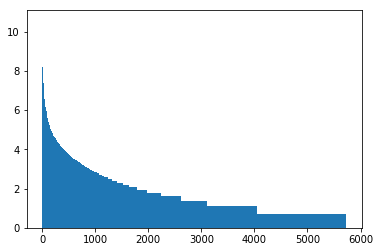

In [7]:
source_words_count = get_word_counts(SOURCE)
plot_word_counts(source_words_count)

top 10 words: ('.', 'je', '?', 'est', 'vous', 'a', 'pas', 'il', 'de', 'ne')


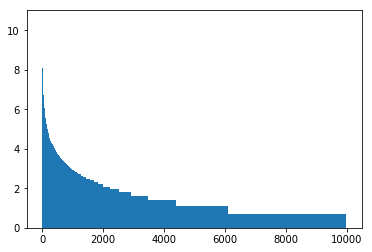

In [8]:
source_words_count = get_word_counts(TARGET)
plot_word_counts(source_words_count)

## architecture

![](./pics/encoder_decoder_att.png)

---

## Build Networks

In [7]:
model_idx

1

In [ ]:
enc, dec, loss_function, test_loader, _ = build_model(model_idx, modelcode_small[model_idx-1], lang1, lang2, 
                                                      file_path='./data/en_fa/', file_type='small')

In [15]:
for i, batch in enumerate(test_loader):
    inputs, lengths = batch.so
    targets = batch.ta
    
    output, hidden = enc(inputs, lengths.tolist())
    preds, _ = dec(hidden, output, lengths.tolist(), targets.size(1)) # max_len
    break

NameError: name 'enc' is not defined

In [ ]:
def evaluation_bleu(enc, dec, so_ref_dict, loader):
    enc.eval()
    dec.eval()
    bleu_scores = []

    for i, batch in enumerate(loader):
        inputs, lengths = batch.so
        targets = batch.ta

        output, hidden = enc(inputs, lengths.tolist())
        preds, _ = dec(hidden, output, lengths.tolist(), targets.size(1)) # max_len

        loss = loss_function(preds, targets.view(-1))
        valid_losses.append(loss.item())
            
    return valid_losses

In [9]:
def build(config, SOURCE, TARGET):
    enc = Encoder(len(SOURCE.vocab), config.EMBED, config.HIDDEN, config.NUM_HIDDEN, bidrec=True)
    dec = Decoder(len(TARGET.vocab), config.EMBED, 2*config.HIDDEN, hidden_size2=config.HIDDEN2, \
                  sos_idx=SOURCE.vocab.stoi['<s>'], method=config.METHOD, USE_CUDA=USE_CUDA)
    if USE_CUDA:
        enc = enc.cuda()
        dec = dec.cuda()

    loss_function = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi['<pad>'])
    return enc, dec, loss_function

In [10]:
def build_model(model_idx, code, lang1, lang2, file_path='./data/en_fa/', file_type='small', device=-1):
    config, test_data, test_loader, SOURCE, TARGET = get_model_config(code, lang1, lang2, device=device,
                                                                      file_path=file_path, file_type=file_type)
    enc, dec, loss_function = build(config, SOURCE, TARGET)
    enc.eval()
    dec.eval()
    
    enc_model_path = './data/model/{0}_{1}/{0}-{1}{2}.enc'.format(lang1, lang2, model_idx)
    dec_model_path = './data/model/{0}_{1}/{0}-{1}{2}.dec'.format(lang1, lang2, model_idx)
    enc.load_state_dict(torch.load(enc_model_path))
    dec.load_state_dict(torch.load(dec_model_path))
    return enc, dec, loss_function, test_loader, test_data

## Load model parameters & test

It's not proper way using "cross entropy loss" to measure translation is translated well. Better use BLEU score. Lefted `To do` in the future.

In [11]:
for i, code in enumerate(modelcode_small, 1):
    enc, dec, loss_function, test_loader, _ = build_model(code, lang1, lang2, 
                                                           file_path='./data/en_fa/', file_type='small')
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 1 | test_losses: 3.36296660900116
model 2 | test_losses: 2.861001229286194
model 3 | test_losses: 2.1414837181568145
model 4 | test_losses: 2.0284644186496736
model 5 | test_losses: 2.00683012008667
model 6 | test_losses: 1.96327902674675
model 7 | test_losses: 1.9139957845211029
model 8 | test_losses: 2.05319704413414
model 9 | test_losses: 2.1222559452056884
model 10 | test_losses: 2.9495986819267275
model 11 | test_losses: 2.034853482246399
model 12 | test_losses: 2.0189727544784546
model 13 | test_losses: 2.2303336381912233
model 14 | test_losses: 2.2022975087165833


In [13]:
for i, code in enumerate(modelcode_filtered, 15):
    enc, dec, loss_function, test_loader, _ = build_model(code, lang1, lang2, 
                                                           file_path='./data/en_fa/', file_type='filtered')
    
    test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
    print('model {} | test_losses: {}'.format(i, np.mean(test_losses)))

model 15 | test_losses: 2.2322555065155028
model 16 | test_losses: 2.2234701037406923


## Visualize Attention

In [14]:
# borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

======== Model 1 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas pas seul .


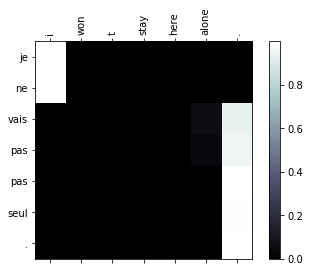

======== Model 2 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas pas ici seul .


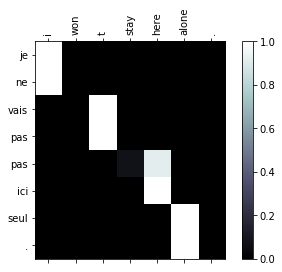

======== Model 3 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne ne pas ici ici .


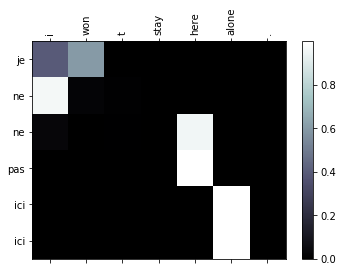

======== Model 4 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne rester pas ici .


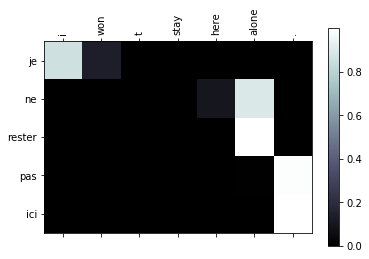

======== Model 5 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas ici ici .


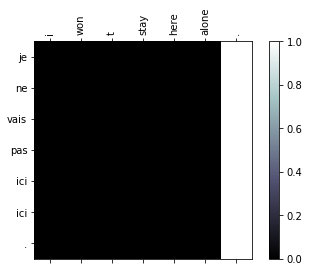

======== Model 6 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas pas ici .


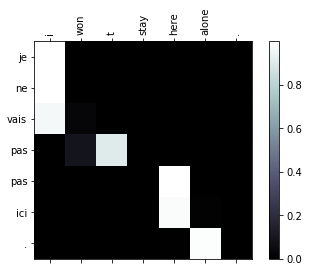

======== Model 7 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas ici ici .


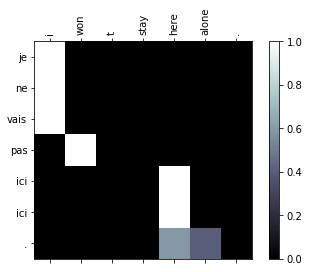

======== Model 8 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas seul .


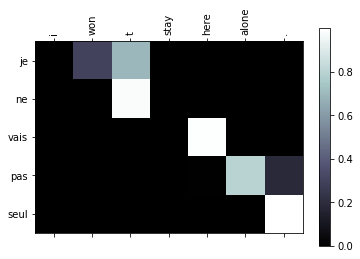

======== Model 9 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne me pas rester la .


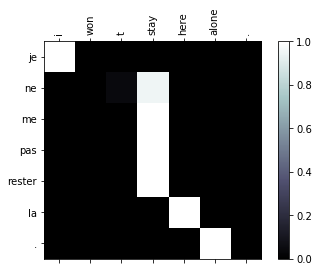

======== Model 10 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne suis pas pas .


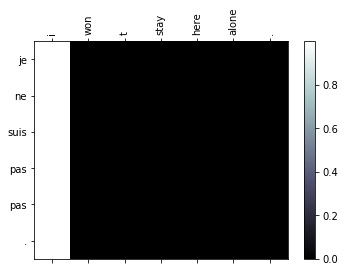

======== Model 11 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne rester pas ici .


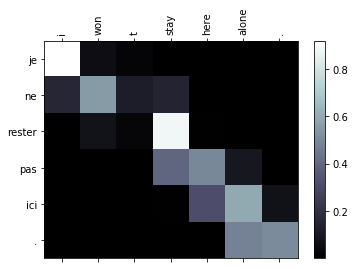

======== Model 12 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne ne pas ici .


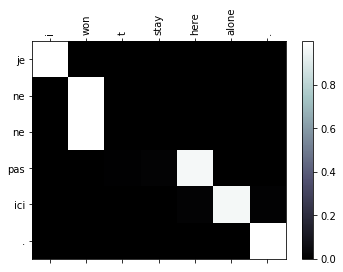

======== Model 13 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne rester pas rester ici .


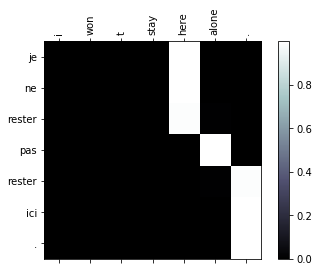

======== Model 14 ========
Source :  i won t stay here alone .
Truth :  je ne resterai pas ici seul .
Prediction :  je ne vais pas ici .


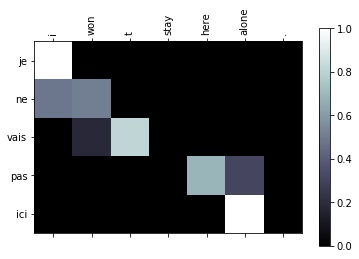

In [18]:
i = 1
file_type = 'small'
model_type = modelcode_small

_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)

test = random.choice(test_data)
source_sentence = test.so
target_sentence = test.ta

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 1):
    enc, dec, _, _, _ = build_model(code, lang1, lang2, file_path='./data/en_fa/', file_type=file_type)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))

    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])

======== Model 15 ========
Source :  tom really wants to lose weight .
Truth :  tom veut vraiment perdre du poids .
Prediction :  tom veut perdre du poids poids


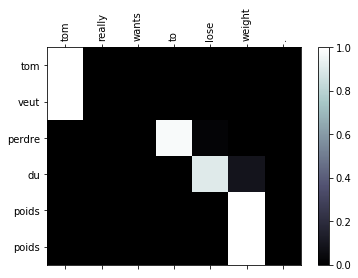

======== Model 16 ========
Source :  tom really wants to lose weight .
Truth :  tom veut vraiment perdre du poids .
Prediction :  tom tom vraiment perdre perdre .


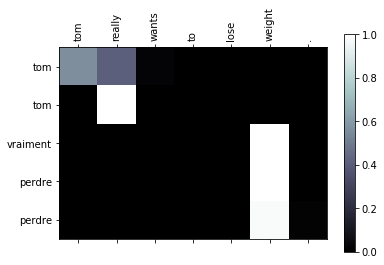

In [16]:
i = 1
file_type = 'filtered'
model_type = modelcode_filtered
_, test_data, _, SOURCE, TARGET = get_model_config(model_type[i-1], lang1, lang2, file_type=file_type)

test = random.choice(test_data)
source_sentence = test.so
target_sentence = test.ta

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

for i, code in enumerate(model_type, 15):
    enc, dec, _, _, _ = build_model(code, lang1, lang2, file_path='./data/en_fa/', file_type=file_type)
    
    output, hidden = enc(s, [s.size(1)])
    pred, attn = dec.decode(hidden, output, [s.size(1)])
    pred_sentence = [TARGET.vocab.itos[i] for i in pred if i not in [2, 3]]
    print('======== Model {} ========'.format(i))
    print('Source : ', ' '.join(source_sentence))
    print('Truth : ', ' '.join(target_sentence))
    print('Prediction : ', ' '.join(pred_sentence))

    if USE_CUDA:
        attn = attn.cpu()

    show_attention(source_sentence, pred_sentence, attn.data[1:-1])